In [1]:
# show log-max assumption
# show reconstruction using FHMM to de-noise
# show how correct state is found when there is a lot of noise
import numpy as np

# view data
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/fhmm', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import pandas as pd
import importlib
from whale.setup import get_data, constants, annotations
importlib.reload(get_data)
importlib.reload(annotations)
importlib.reload(constants)
from python_speech_features import mfcc, delta
import numpy as np
from spafe.utils import vis
import matplotlib.pyplot as plt
import IPython
from scipy.io import wavfile
from final.useful import *

In [3]:
get_data_whale = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.SWOOPS_LABELS_A,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)

get_data_noise = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.HUMPBACK_LABEL_A_NOISE,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)


In [4]:
import librosa
_, audio_fs = librosa.load(constants.HUMPBACK_WAV_A, sr=None)

In [5]:
from spafe.features import mfcc

# normalisation / feature extraction
import librosa.util as util
audio_normalised = util.normalize(get_data_whale.audio)

from spafe.features import mfcc, lfcc
from spafe.utils.preprocessing import zero_handling

nfilts = 400

# create labels and data
whale_samples = []
whale_features = []
noise_features = []
noise_samples = []
for i in range(len(get_data_whale.annotations.annotations)):
    annot = get_data_whale.annotations.annotations[i]
    sample = audio_normalised[annot.start:annot.end]
    whale_samples.append(sample)
    feat, _ = lfcc.linear_spectrogram(sig=sample, fs=audio_fs, nfilts=nfilts, nfft=512)
    features_no_zero = zero_handling(feat)
    log_features = np.log(features_no_zero)
    whale_features.append(log_features)

for i in range(len(get_data_noise.annotations.annotations)):
    annot = get_data_noise.annotations.annotations[i]
    sample = audio_normalised[annot.start:annot.end]
    noise_samples.append(sample)
    feat, _ = lfcc.linear_spectrogram(sig=sample, fs=audio_fs, nfilts=nfilts, nfft=512)
    features_no_zero = zero_handling(feat)
    log_features = np.log(features_no_zero)
    noise_features.append(log_features)

# hmm_noise.fit()

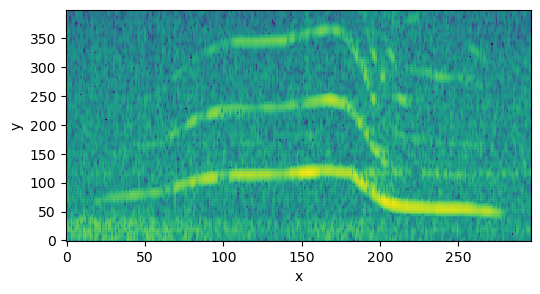

In [6]:
vis_helper(whale_features[0])

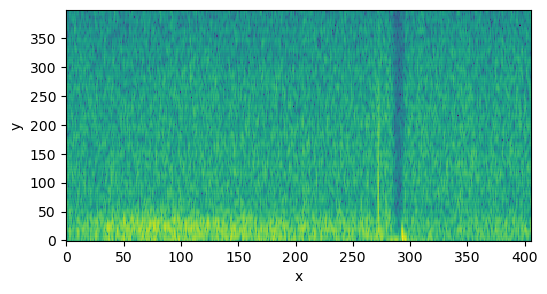

In [7]:
vis_helper(noise_features[20])

In [8]:
combined = whale_features[0] + (noise_features[20][0:len(whale_features[0]),:])

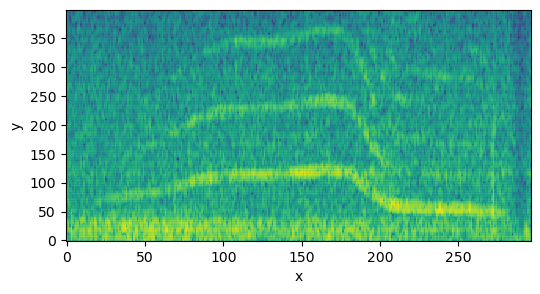

In [9]:
vis_helper(combined)

In [88]:
# not completely sure about how to accommodate for power between signals

from hmmlearn.hmm import GaussianHMM

hmm_whale = GaussianHMM(5)
[len(feat) for feat in whale_features]
hmm_whale.fit(np.concatenate(whale_features))

GaussianHMM(n_components=5)

In [90]:
sample_test = hmm_whale.sample(200)

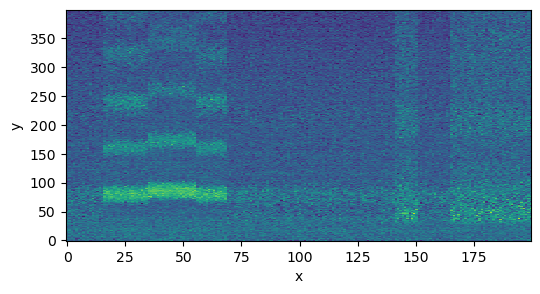

In [91]:
vis_helper(sample_test[0])

In [13]:
hmm_noise = GaussianHMM(2)
hmm_noise.fit(np.concatenate(noise_features))

GaussianHMM(n_components=2)

In [92]:
def get_feature(sample, fs, nfilts=400):
    feat, _ = lfcc.linear_spectrogram(sig=sample, fs=fs, nfilts=nfilts, nfft=512)
    features_no_zero = zero_handling(feat)
    log_features = np.log(features_no_zero)
    return log_features

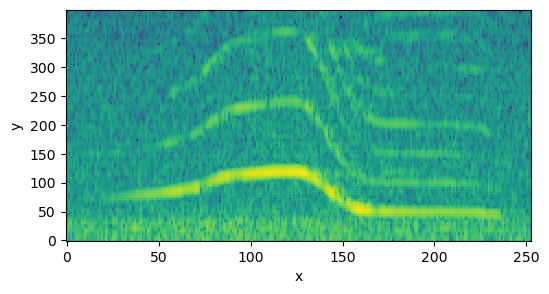

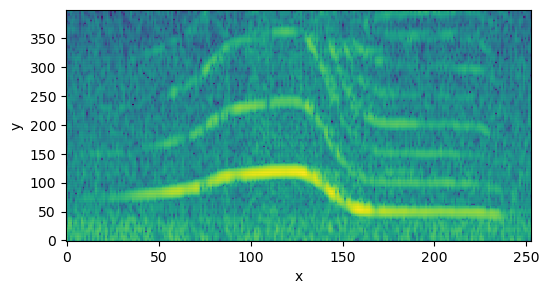

In [93]:
combined_time_domain = whale_samples[2] + (noise_samples[20][0:len(whale_samples[2])])
# plt.plot(combined_time_domain)
combined_features = get_feature(combined_time_domain, audio_fs)
vis_helper(combined_features)
vis_helper(whale_features[2])

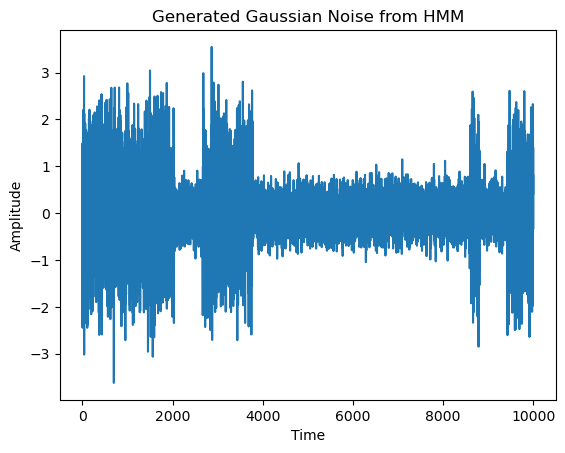

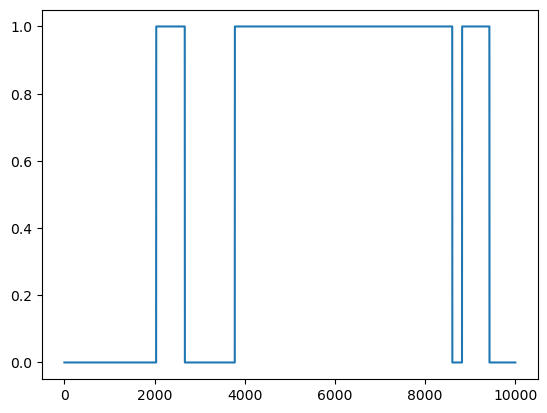

In [94]:
def generate_gaussian_noise(num_samples, power_a, power_b):
    # Define the parameters of the HMM
    startprob = np.array([0.5, 0.5])
    transmat = np.array([[0.999, 0.001], [0.001, 0.999]])  # Transition matrix
    means = np.array([[0.0], [0.0]])  # Mean values for each state
    covars = np.array([[[power_a]],[[power_b]]])  # Covariance matrices for each state

    # Create a two-state HMM
    model = GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
    model.n_features = 1
    model.startprob_ = startprob
    model.transmat_ = transmat
    model.means_ = means
    model.covars_ = covars

    # Generate samples from the HMM
    noise, states = model.sample(num_samples)

    return noise, states

# Example usage:
num_samples = 10000
power_ratio = 0.8
generated_noise, generated_states = generate_gaussian_noise(num_samples, 1, 0.1)

# Plot the generated noise
import matplotlib.pyplot as plt

plt.plot(generated_noise)
plt.title("Generated Gaussian Noise from HMM")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

plt.plot(generated_states)


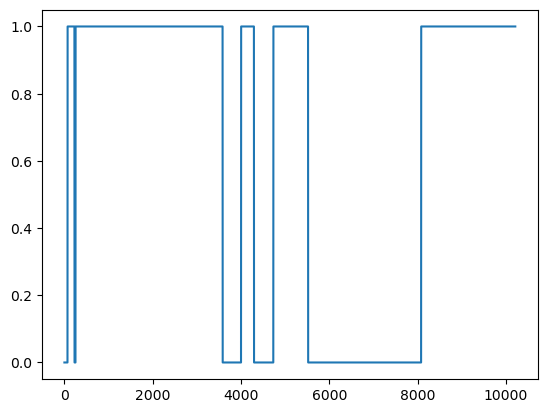

In [95]:
import noisey
importlib.reload(noisey)

gauss_noise, ss = generate_gaussian_noise(len(whale_samples[2]), noisey.get_noise_avg_watts(whale_samples[2], 20), noisey.get_noise_avg_watts(whale_samples[2], 20))
plt.plot(ss)

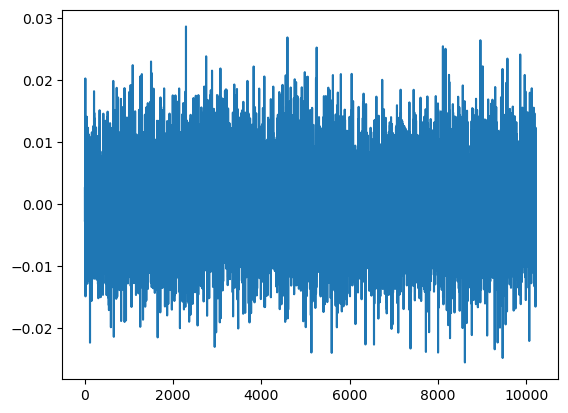

In [96]:
combined_time_domain = whale_samples[2] + gauss_noise.flatten()

plt.plot(gauss_noise)
# plt.plot(combined_time_domain)

# vis_helper(combined_features)
# vis_helper(whale_features[2])

In [97]:
combined_features = get_feature(combined_time_domain, audio_fs)

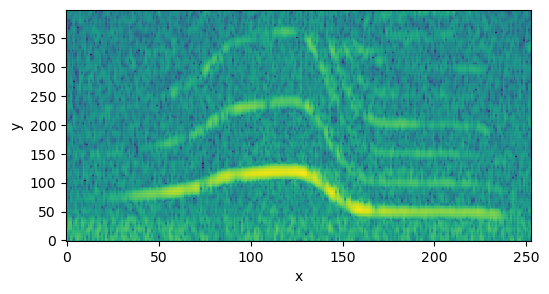

In [98]:
vis_helper(combined_features)

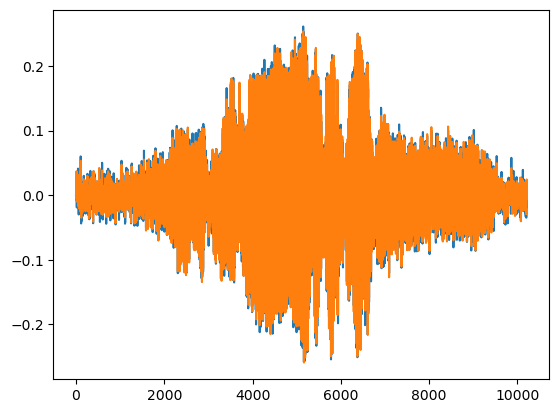

In [99]:
plt.plot(combined_time_domain)
plt.plot(whale_samples[2])
plt.show()

In [100]:
# noise_hmm

hmm_noise = GaussianHMM(2)
hmm_noise.fit(gauss_noise)

GaussianHMM(n_components=2)

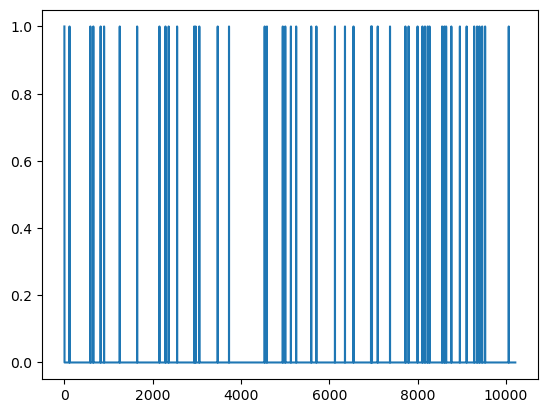

In [101]:
_, ss = hmm_noise.decode(gauss_noise)
plt.plot(ss)

In [102]:
import hmmUtils
importlib.reload(hmmUtils)
ViterbiAlgorithmParallel = hmmUtils.doViterbiAlgorithmParallel(combined_features[:100,:], hmm_whale, hmm_noise)